In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm import tqdm

custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [2]:
import lightning as L

from txtox.data.datamodules import AnnDataGraphDataModule
from txtox.models.gnn_het_reg_2d import LitGNNHetReg2d
from txtox.utils import get_paths

n_genes = 500
n_labels = 126
paths = get_paths()

# data
datamodule = AnnDataGraphDataModule(
    data_dir=paths["data_root"],
    file_names=["VISp_nhood.h5ad"],
    batch_size=1,
    spatial_coords=["x_section", "y_section", "z_section"],
)

# model
expname = "20241113_131356_VISp_nhood_GNNhetReg_attres_2d"
checkpoint_path = paths["data_root"] + f"checkpoints/{expname}"
model = LitGNNHetReg2d.load_from_checkpoint(
    checkpoint_path + "/epoch=192-val_rmse_overall=0.17.ckpt", input_size=n_genes, n_labels=n_labels
)

# setup for predictions
trainer = L.Trainer()
predictions = trainer.predict(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
xy_pred = np.concatenate([p[0].reshape(1, -1) for p in predictions], axis=0)
xy_L_pred = np.concatenate([p[1].reshape(1, 2, 2) for p in predictions], axis=0)
celltype_pred = np.concatenate([p[2].reshape(1, -1) for p in predictions], axis=0)
print(xy_pred.shape)
print(xy_L_pred.shape)
print(celltype_pred.shape)

(61884, 2)
(61884, 2, 2)
(61884, 126)


In [4]:
# convert L to covariance matrices using L @ L.T
xy_cov_pred = xy_L_pred @ xy_L_pred.transpose(0, 2, 1)
print(xy_cov_pred.shape)

(61884, 2, 2)


In [5]:
# del predictions
xy = []
celltype = []
section_idx = []

i = 0
for batch in tqdm(datamodule.predict_dataloader()):
    _, _, xy_batch, section_idx_batch, celltype_batch = model.proc_batch(batch)
    xy.append(xy_batch.squeeze(0)[-1, :].numpy())
    section_idx.append(section_idx_batch.squeeze(0)[-1].numpy().reshape(-1))
    celltype.append(celltype_batch.squeeze(0)[-1].numpy().reshape(-1))

100%|██████████| 61884/61884 [04:54<00:00, 210.07it/s]


In [6]:
xy = np.array(xy)
celltype = np.array(celltype).squeeze()
section_idx = np.array(section_idx).squeeze()

In [7]:
print(xy.shape)

(61884, 2)


In [8]:
# calculates the eigenvalues and eigenvectors for all covariance matrices
eigvals, eigvecs = np.linalg.eig(xy_cov_pred)

In [9]:
# check if the eigenvectors are columns of the covariance matrix
ind = 10  # some arbitrary cell
sigma = xy_cov_pred[ind].squeeze()
v0 = eigvecs[ind, :, 0]
v1 = eigvecs[ind, :, 1]

lam = eigvals[ind, :]
# check if the eigenvectors are columns
assert np.allclose(sigma @ v0 / v0, lam[0])
assert np.allclose(sigma @ v1 / v1, lam[1])

assert np.allclose(np.linalg.norm(v0, axis=0), 1)
assert np.allclose(np.linalg.norm(v1, axis=0), 1)

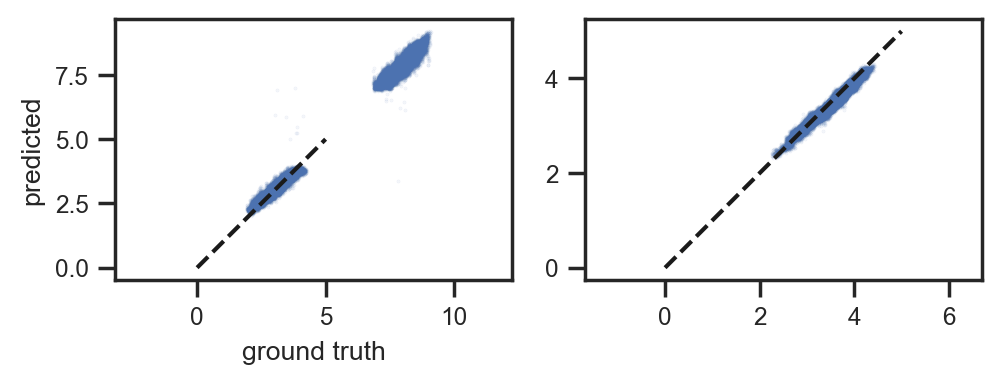

In [10]:
# rough checks for order of the cells in xyz (ground truth) and xyz_pred (predictions)
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
for i in range(2):
    ax[i].scatter(xy[:, i], xy_pred[:, i], s=0.1, alpha=0.1)
    ax[i].plot([0, 5], [0, 5], c="k", ls="--")  # 1-1 line
    ax[i].axis("equal")
ax[0].set(xlabel="ground truth", ylabel="predicted")
plt.tight_layout()
plt.show()

In [11]:
path = get_paths()["data_root"] + "VISp_nhood.h5ad"
adata = ad.read_h5ad(path)

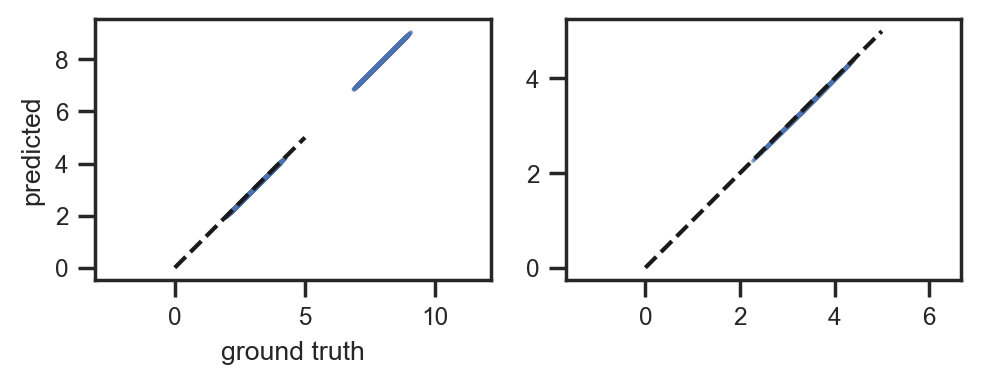

In [12]:
# make sure that data loader and ann data file list cells in the same order
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
for i, coord in enumerate(["x_section", "y_section"]):
    ax[i].scatter(adata.obs[coord], xy[:, i], s=0.1, alpha=0.1)
    ax[i].plot([0, 5], [0, 5], c="k", ls="--")  # 1-1 line
    ax[i].axis("equal")
ax[0].set(xlabel="ground truth", ylabel="predicted")
plt.tight_layout()
plt.show()

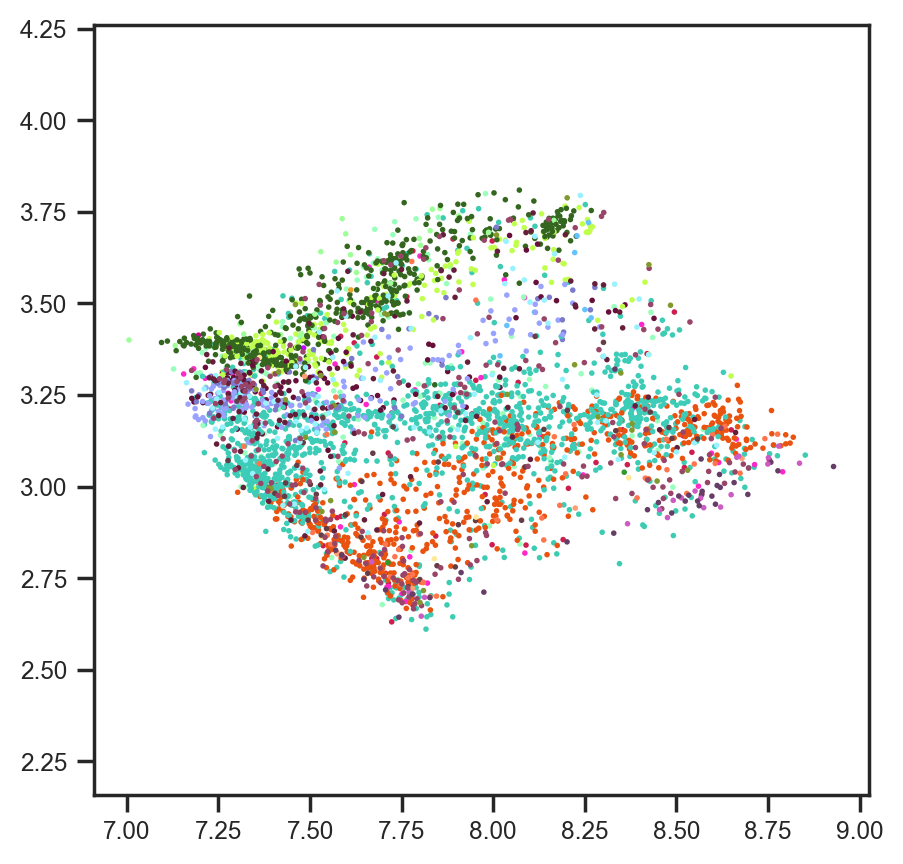

In [13]:
ind = np.where((adata.obs["z_section"] == 5.4) & (adata.obs["x_section"] > 6))[0]

f, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(xy_pred[ind, 0], xy_pred[ind, 1], s=1, c=adata.obs["subclass_color"].iloc[ind], alpha=1)
plt.axis("equal")
plt.show()

In [14]:
display(adata.obs[["parcellation_category", "parcellation_division", "parcellation_structure"]].head(3))

,parcellation_category,parcellation_division,parcellation_structure
0,grey,Isocortex,VISp
1,grey,Isocortex,VISp
2,grey,Isocortex,VISp


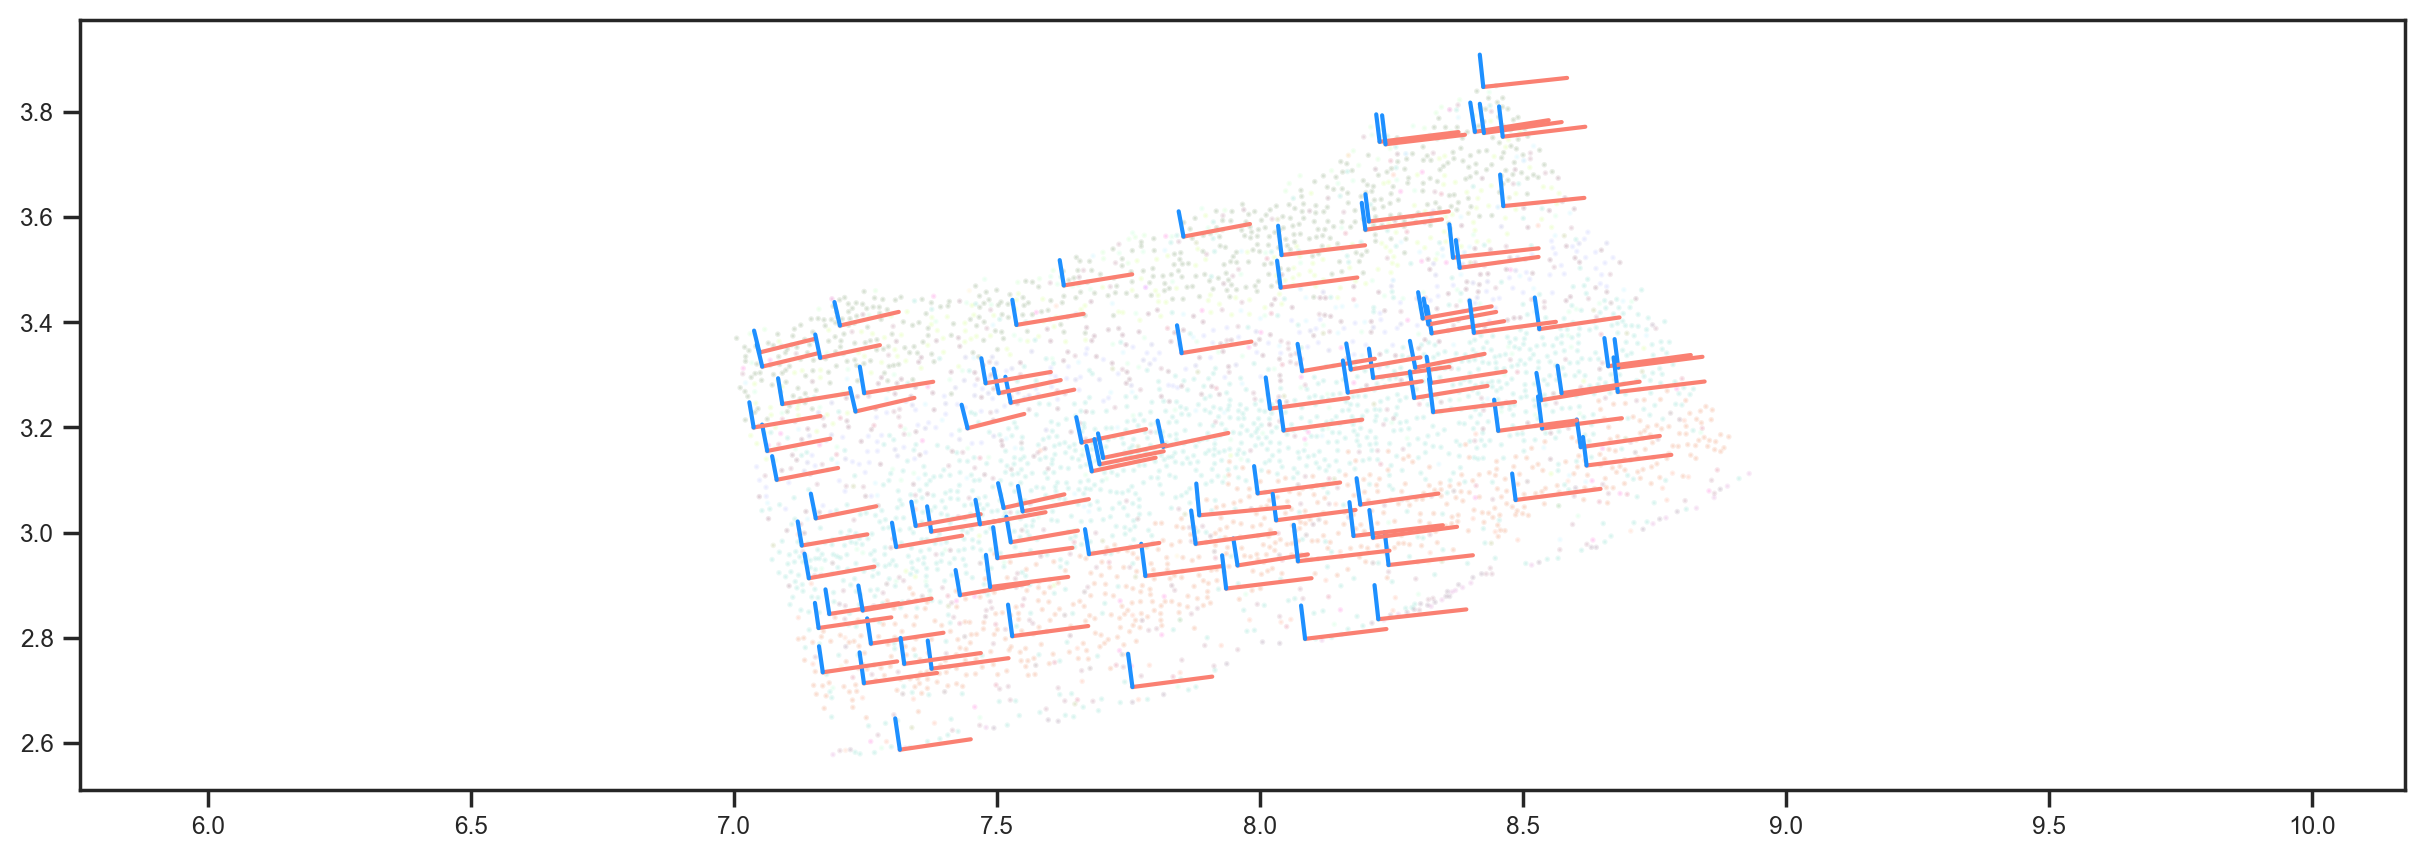

In [15]:
# pick n_arrows from ind randomly
scale = 0.5
n_arrows = 100
arrow_ind = np.random.choice(ind, n_arrows, replace=False)
colors = ["salmon", "dodgerblue"]


f, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(xy[ind, 0], xy[ind, 1], s=1, c=adata.obs["subclass_color"].iloc[ind], alpha=0.1)

for arr in arrow_ind:
    point = xy[arr]
    srtind = np.argsort(eigvals[arr, :])[::-1]
    for j in range(2):
        vec = eigvecs[arr, :, srtind[j]]
        lam = eigvals[arr, srtind[j]] ** 0.5
        ax.plot(
            [point[0], point[0] + vec[0] * lam * scale],
            [point[1], point[1] + vec[1] * lam * scale],
            c=colors[j],
            alpha=1,
        )
ax.axis("equal")
plt.show()

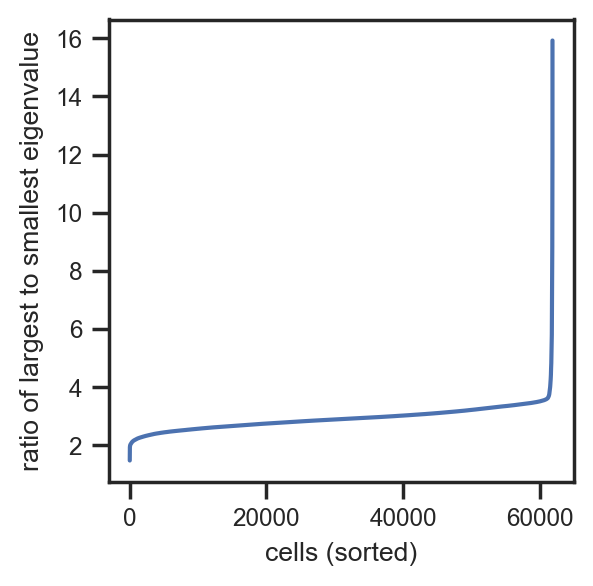

In [16]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(np.sort(np.max(eigvals, axis=1) ** 0.5 / np.min(eigvals, axis=1) ** 0.5))
ax.set(xlabel="cells (sorted)", ylabel="ratio of largest to smallest eigenvalue")
plt.show()

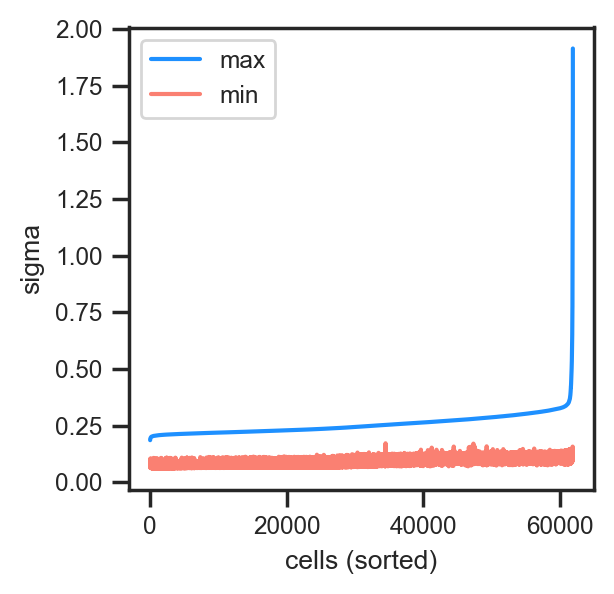

In [17]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
max_sig = np.max(eigvals, axis=1) ** 0.5
min_sig = np.min(eigvals, axis=1) ** 0.5
sortind = np.argsort(max_sig)
ax.plot(max_sig[sortind], label="max", c="dodgerblue")
ax.plot(min_sig[sortind], label="min", c="salmon")
ax.set(xlabel="cells (sorted)", ylabel="sigma")
ax.legend()
plt.show()

In [18]:
# data for clustering
data = {
    "eigvals": eigvals,
    "eigvecs": eigvecs,
    "xy_cov_pred": xy_cov_pred,
    "xy_pred": xy_pred,
    "xy": xy,
    "section_idx": section_idx,
    "subclass": adata.obs["subclass"].values,
    "subclass_color": adata.obs["subclass_color"].values,
}

import pickle

pickle.dump(data, open(paths["data_root"] + f"het_reg_2d_results.pkl", "wb"))

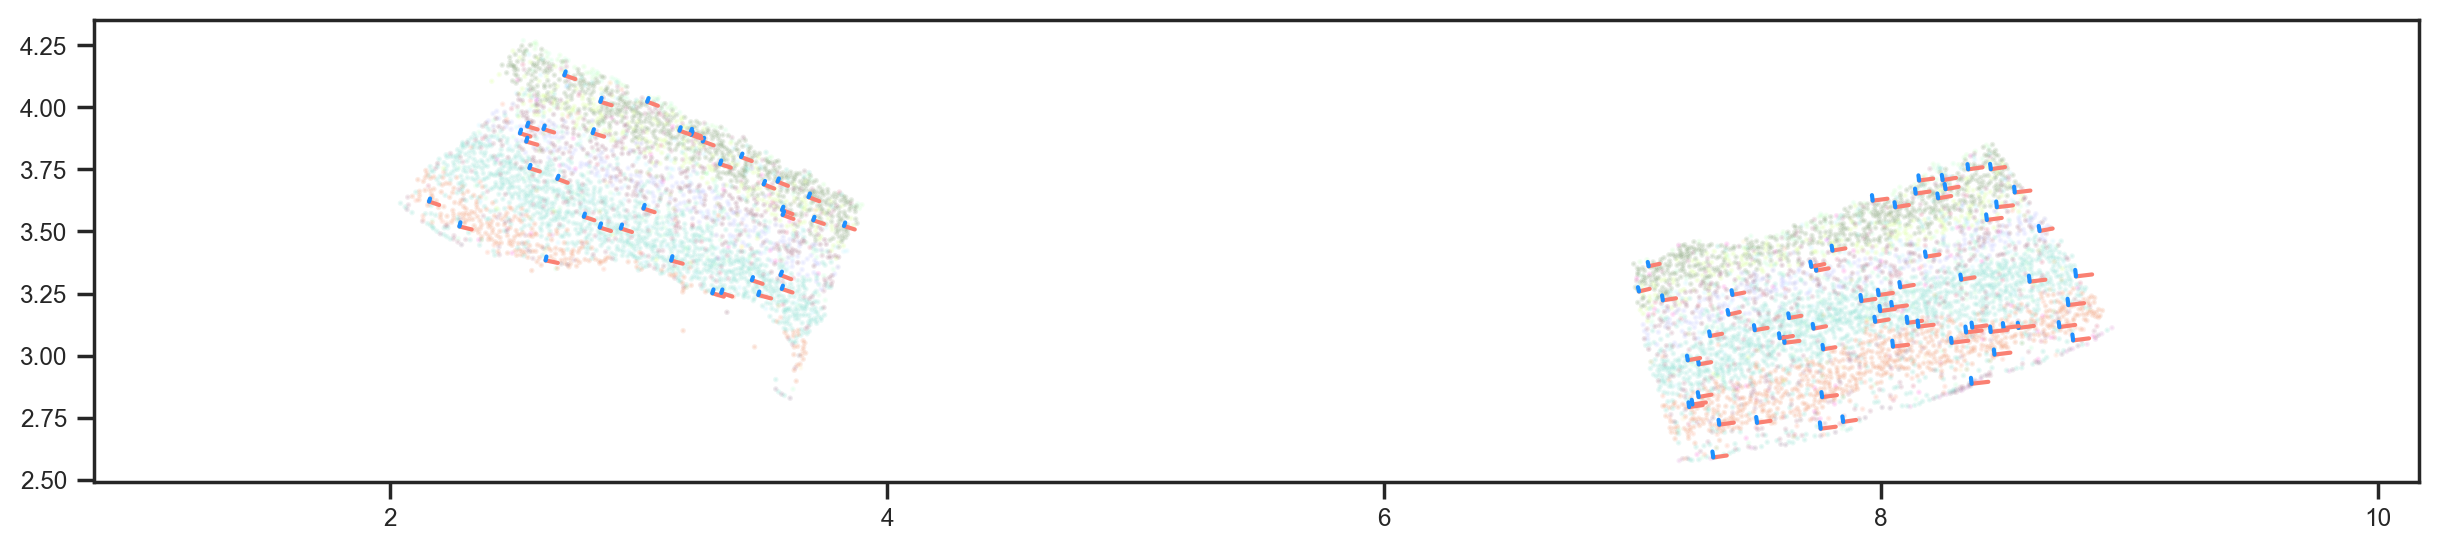

In [19]:
data = pickle.load(open(paths["data_root"] + f"het_reg_2d_results.pkl", "rb"))

ind = np.where(data["section_idx"] == 5.4)[0]
f, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.scatter(data["xy"][ind, 0], data["xy"][ind, 1], s=1, c=data["subclass_color"][ind], alpha=0.1)
arrow_ind = np.random.choice(ind, 100, replace=False)
scale = 0.2
colors = ["salmon", "dodgerblue"]
for arr in arrow_ind:
    point = data["xy"][arr]
    for j in range(2):
        vec = data["eigvecs"][arr, :, j]
        lam = data["eigvals"][arr, j] ** 0.5  # get sigma from var
        ax.plot(
            [point[0], point[0] + vec[0] * lam * scale],
            [point[1], point[1] + vec[1] * lam * scale],
            c=colors[j],
            alpha=1,
        )
ax.axis("equal")
plt.show()

In [20]:
pd.DataFrame(data["subclass"]).value_counts()

0                        
006 L4/5 IT CTX Glut         16551
007 L2/3 IT CTX Glut          9865
030 L6 CT CTX Glut            7506
319 Astro-TE NN               5307
333 Endo NN                   3751
004 L6 IT CTX Glut            3136
022 L5 ET CTX Glut            2531
052 Pvalb Gaba                2113
005 L5 IT CTX Glut            1921
327 Oligo NN                  1896
053 Sst Gaba                  1458
032 L5 NP CTX Glut             839
326 OPC NN                     768
334 Microglia NN               748
046 Vip Gaba                   713
049 Lamp5 Gaba                 574
331 Peri NN                    534
330 VLMC NN                    442
029 L6b CTX Glut               423
329 ABC NN                     299
332 SMC NN                     143
001 CLA-EPd-CTX Car3 Glut      111
047 Sncg Gaba                   76
028 L6b/CT ENT Glut             53
003 L5/6 IT TPE-ENT Glut        28
056 Sst Chodl Gaba              27
002 IT EP-CLA Glut              22
051 Pvalb chandelier Gaba    